<a href="https://colab.research.google.com/github/luigiselmi/finstat/blob/main/hilpisch/ch13_bayesian_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch.13 Bayesian statistics
The goal of a statistical analysis of a process is to figure out what are the variables that play a role and the relationships between them. Usually the observations have a random component. We might have a model of the process, for example we might start with two variables: one dependent variable y and one independent variable x. We might make two additional assumptions: the relationship between y and x is linear and the random compnent is normally distributed. The next step is to assess our assumptions using a sample of observations.

In [1]:
import math
import numpy as np
import scipy.stats as scs
import scipy.optimize as sco
from scipy import interpolate
import pymc as pm
import statsmodels.api as sm
import pandas as pd
from pylab import plt, mpl
import warnings
warnings.filterwarnings('ignore')
print('Matplotlib version: {}'.format(mpl.__version__))
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('PyMC version: {}'.format(pm.__version__))
print('Statsmodels version: {}'.format(sm.__version__))

Matplotlib version: 3.10.0
NumPy version: 2.0.2
Pandas version: 2.2.2
PyMC version: 5.26.1
Statsmodels version: 0.14.5


We can simulate a linear process by sampling the random component from a standard distribution with mean=0 and standard deviation std=1

$$y = a + bx + \epsilon$$

In [2]:
size = 500
x = np.linspace(0, 10, size)
y = 4 + 2 * x + np.random.standard_normal(size) * 2

Text(0, 0.5, 'y')

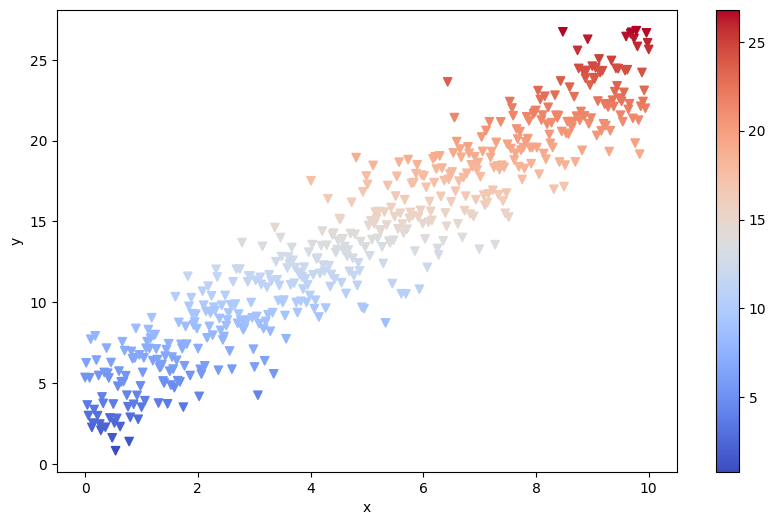

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

## Ordinary least squares
Now we can fit the simulated data using the [NumPy Polynomial.fit()](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html) method that performs a polynomial fit using the least squares method. Since we assume the relationship is linear we set the degree of the polynomial to 1. The method returns the coefficients of the polynomial.

In [4]:
from numpy.polynomial import Polynomial
reg = Polynomial.fit(x, y, deg=1)
reg

Polynomial([13.9918838 , 10.31413185], domain=[ 0., 10.], window=[-1.,  1.], symbol='x')

In [6]:
a = reg.convert().coef[0]
b = reg.convert().coef[1]
print('Linear coefficients\na={:.2f}\nb={:.2f}'.format(a, b))

Linear coefficients
a=3.68
b=2.06


We plot the linear fit to the data

Text(0, 0.5, 'y')

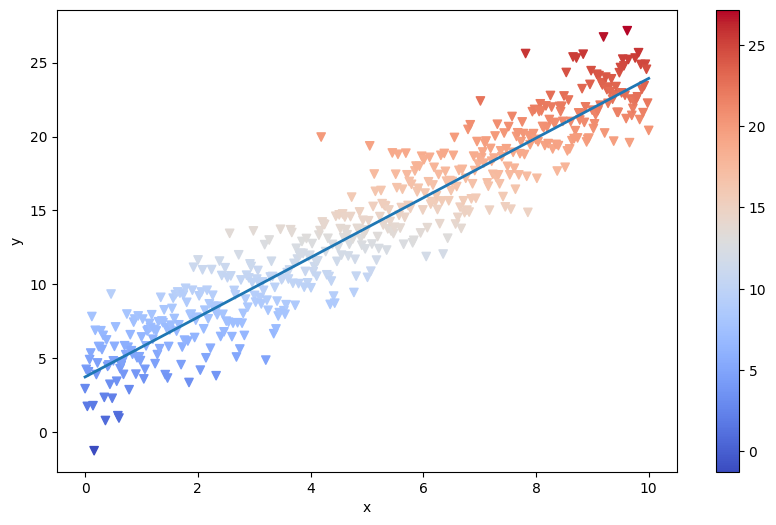

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
y_fit = a + b * x
plt.plot(x, y_fit, lw=2.0)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
%%time
with pm.Model() as model:
  # model
  a = pm.Normal('a', mu=0, sigma=20)
  b = pm.Normal('b', mu=0, sigma=10)
  sigma = pm.Uniform('sigma', lower=0, upper=10)
  y_est = a + b * x
  likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y)
  # inference
  start = pm.find_MAP()
  step = pm.NUTS()
  trace = pm.sample(90, tune=1000, start=start, progressbar=True)

Output()

Output()

CPU times: user 5.11 s, sys: 134 ms, total: 5.24 s
Wall time: 5.17 s


In [ ]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.722,0.189,3.457,4.101,0.018,0.016,116.0,103.0,1.01
b,2.022,0.033,1.965,2.082,0.003,0.003,126.0,100.0,1.02
sigma,1.946,0.080,1.787,2.077,0.008,0.006,104.0,79.0,1.01


In [ ]:
trace['posterior']

<xarray.Dataset> Size: 5kB
Dimensions:  (chain: 2, draw: 90)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 720B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
Data variables:
    a        (chain, draw) float64 1kB 3.86 3.87 3.87 ... 3.928 4.035 3.506
    b        (chain, draw) float64 1kB 2.009 1.978 1.978 ... 1.972 1.982 2.069
    sigma    (chain, draw) float64 1kB 1.928 2.063 2.063 ... 1.818 1.771 2.126
Attributes:
    created_at:                 2025-11-24T14:27:54.033259+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              2.171654224395752
    tuning_steps:               1000

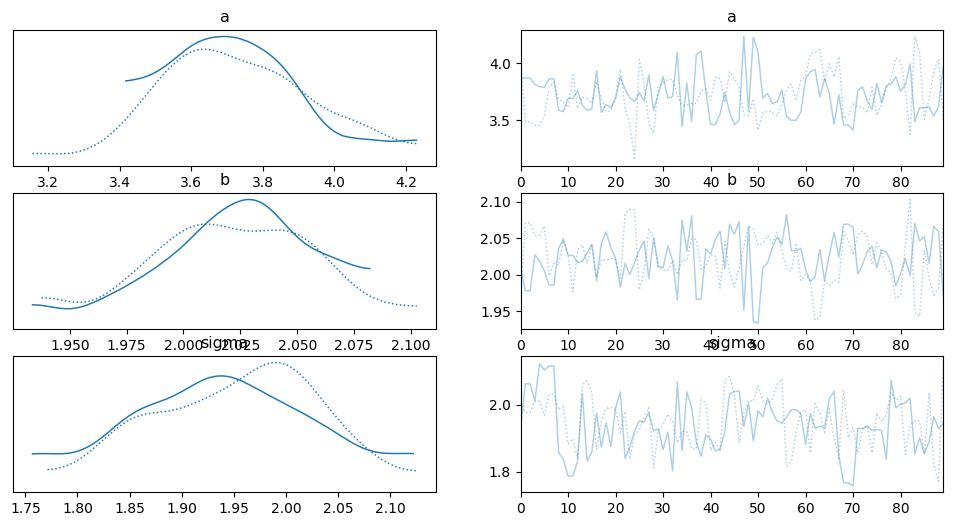

In [ ]:
pm.plot_trace(trace, lines={'alpha': 4, 'beta': 2, 'sigma': 2});

ValueError: operands could not be broadcast together with shapes (90,) (500,) 

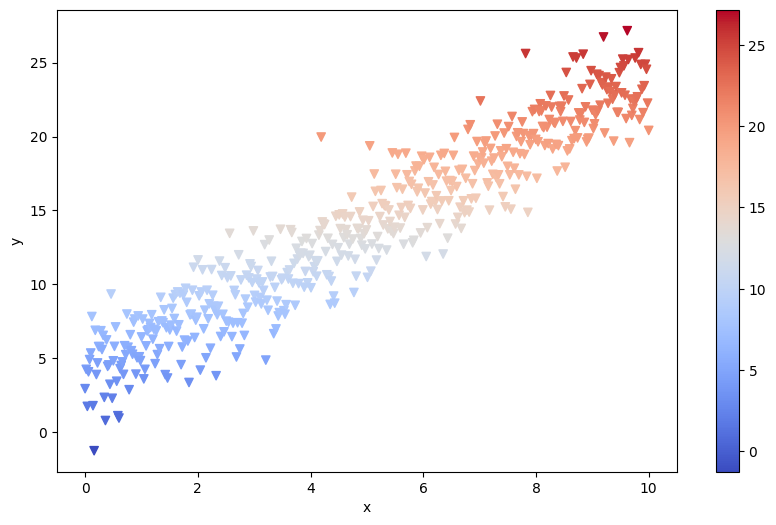

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
  plt.plot(x, trace['posterior']['a'][i] + trace['posterior']['b'][i] * x)